In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os

In [7]:
df = pd.read_csv("final_dataset.csv")

feature_cols = df.columns.drop(['participant_id', 'age', 'gender', 'diabetes', 'ht', 'asthma', 'fever', 'smoker', 'cld', 'ihd'])
label_cols = ['diabetes', 'ht', 'asthma', 'fever', 'smoker', 'cld', 'ihd']

scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols])
y = df[label_cols].values.astype(np.float32)

noise_dim = 100
label_dim = y.shape[1]
feature_dim = X.shape[1]

In [8]:
def build_generator():
    label_input = tf.keras.Input(shape=(label_dim,))
    noise_input = tf.keras.Input(shape=(noise_dim,))
    merged = tf.keras.layers.Concatenate()([noise_input, label_input])
    x = tf.keras.layers.Dense(128, activation='relu')(merged)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(feature_dim)(x)
    return tf.keras.Model([noise_input, label_input], output)

def build_discriminator():
    label_input = tf.keras.Input(shape=(label_dim,))
    feature_input = tf.keras.Input(shape=(feature_dim,))
    merged = tf.keras.layers.Concatenate()([feature_input, label_input])
    x = tf.keras.layers.Dense(256, activation='relu')(merged)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([feature_input, label_input], output)


In [9]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

noise = tf.keras.Input(shape=(noise_dim,))
label = tf.keras.Input(shape=(label_dim,))
gen_features = generator([noise, label])
discriminator.trainable = False
validity = discriminator([gen_features, label])
combined = tf.keras.Model([noise, label], validity)
combined.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
batch_size = 64
epochs = 5000
half_batch = batch_size // 2

for epoch in range(epochs):
    idx = np.random.randint(0, X.shape[0], half_batch)
    real_features = X[idx]
    real_labels = y[idx]

    noise = np.random.normal(0, 1, (half_batch, noise_dim))
    fake_features = generator.predict([noise, real_labels], verbose=0)

    d_loss_real = discriminator.train_on_batch([real_features, real_labels], np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch([fake_features, real_labels], np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    sampled_labels = y[np.random.randint(0, y.shape[0], batch_size)]
    g_loss = combined.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

    if epoch % 500 == 0:
        print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")


c:\Users\Rishi S Etagi\Desktop\medivoice\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.8044] [G loss: 0.6735]
500 [D loss: 5.2309] [G loss: 0.0089]
1000 [D loss: 5.8175] [G loss: 0.0045]
1500 [D loss: 6.1939] [G loss: 0.0030]
2000 [D loss: 6.4760] [G loss: 0.0022]
2500 [D loss: 6.7069] [G loss: 0.0018]
3000 [D loss: 6.9027] [G loss: 0.0015]
3500 [D loss: 7.0772] [G loss: 0.0013]
4000 [D loss: 7.2323] [G loss: 0.0011]
4500 [D loss: 7.3756] [G loss: 0.0010]


In [ ]:
synthetic_rows = 1000
noise = np.random.normal(0, 1, (synthetic_rows, noise_dim))
sampled_indices = np.random.randint(0, y.shape[0], synthetic_rows)
sampled_labels = y[sampled_indices]

gen_data = generator.predict([noise, sampled_labels], verbose=0)
gen_data = scaler.inverse_transform(gen_data)

synthetic_df = pd.DataFrame(gen_data, columns=feature_cols)
synthetic_df[label_cols] = sampled_labels
synthetic_df.insert(0, 'participant_id', [f'synthetic_{i}' for i in range(synthetic_rows)])

synthetic_df.to_csv("synthetic_cgan_data.csv", index=False)
print("✅ Synthetic data saved as 'synthetic_cgan_data.csv'")

✅ Synthetic data saved as 'synthetic_cgan_data.csv'


In [12]:
import pandas as pd


real_df = pd.read_csv("final_dataset.csv")
synthetic_df = pd.read_csv("synthetic_cgan_data.csv")

real_df = real_df[synthetic_df.columns]  
merged_df = pd.concat([real_df, synthetic_df], ignore_index=True)

merged_df.to_csv("merged_dataset.csv", index=False)
print("✅ Merged dataset saved as 'merged_dataset.csv'")


✅ Merged dataset saved as 'merged_dataset.csv'


📊 Label Distribution:

smoker      102
ht           92
asthma       79
diabetes     55
fever         6
cld           6
ihd           6
dtype: int64


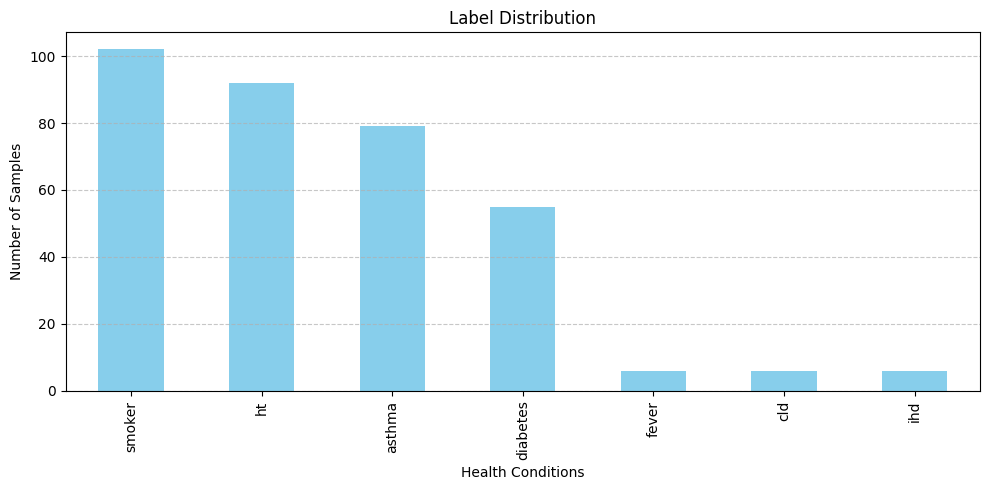

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("merged_dataset.csv")

label_cols = ['diabetes', 'ht', 'asthma', 'fever', 'smoker', 'cld', 'ihd']

df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

label_distribution = df[label_cols].sum().sort_values(ascending=False)

print("📊 Label Distribution:\n")
print(label_distribution)

plt.figure(figsize=(10, 5))
label_distribution.plot(kind='bar', color='skyblue')
plt.title("Label Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Health Conditions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
